In [1]:
import numpy as np
import pandas as pd
import pybamm
import matplotlib.pyplot as plt
from pandas import DataFrame
from utils.generate_new_volume import generate_new_volume, generate_new_volume_anisotropic
from utils.physical_properties import *
from utils.plotting import plot_volume
from skimage.transform import rescale, downscale_local_mean
import seaborn as sns

# 4 phase volumes
# phases = ['Pore','Crack','Particle','CBD']

# Diffusivity function to modify for Pybamm
def lico2_diffusivity(sto, T, coeff):
    """
    LiCo2 diffusivity as a function of stochiometry, in this case the
    diffusivity is taken to be a constant. The value is taken from Dualfoil [1].

    References
    ----------
    .. [1] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """
    #D_ref = 1 * 10 ** (-13)
    D_ref = (coeff / 0.4) * 10 ** (-13) # 0.4 is a random number picked from some GAN runs
    E_D_s = 18550
    arrhenius = pybamm.exp(E_D_s / pybamm.pybamm.constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

# Volume generation
def gen_vol_anisotropic(reduction, subregion_id, subregion, output_sz=512, is_scale_for_reduction=True):
    model_name = 'slicegan_r{}_s{}{}'.format(str(reduction).replace('.', 'p'), str(subregion_id), str(subregion))
    model_path = 'model/{}/{}'.format(model_name, model_name)

    # Need to modify output size so the size of the generated volume is the same regardless of training image resolution
    # lz size table for reference:
    # lz =  4 -> output dim = 64
    # lz =  6 -> output dim = 128
    # lz =  8 -> output dim = 192
    # lz = 10 -> output dim = 256
    # lz = 12 -> output dim = 320
    # lz = 18 -> output dim = 512
    # lz = 24 -> output dim = 704
    # lz = 32 -> output dim = 960
    # lz = 40 -> output dim = 1216
    # lz = 50 -> output dim = 1536
    # lz = 60 -> output dim = 1856
    # lz = 70 -> output dim = 2176
    # lz = 80 -> output dim = 2496
    # lz = 100 -> output dim = 3136
    
    # BIGGEST MY LAPTOP CAN HANDLE IS 512 OUTPUT DIM FOR 20% REDUCTION
    # Makes ~8x1x1 aspect ratio volume, enforces even latent vector dims (they have to be even)
    # as well as minimum size of 4. If output_sz is too small, it won't be 8x1x1.
    if is_scale_for_reduction:
        lz_0 = (np.ceil((((output_sz * reduction / (12.5 * 4)) / 0.2)+64)/(32*2))*2).astype(int)
        lz_1 = (np.ceil((((output_sz * reduction / 12.5) / 0.2)+64)/(32*2))*2).astype(int)
        lz_2 = (np.ceil((((output_sz * reduction) / 0.2)+64)/(32*2))*2).astype(int)
    else:
        lz_0 = (np.ceil(((output_sz / (12.5 * 4)) + 64)/(32*2))*2).astype(int)
        lz_1 = (np.ceil(((output_sz / 12.5) + 64)/(32*2))*2).astype(int)
        lz_2 = (np.ceil((output_sz + 64)/(32*2))*2).astype(int)

    vol = generate_new_volume_anisotropic(model_path=model_path, lz_0=lz_0, lz_1=lz_1, lz_2=lz_2)
    # downscale higher resolution images to avoid taking a really long time, rounding to preseve segmented
    # vol_reduced = np.round(downscale_local_mean(vol, int(reduction/0.2))).astype(int)
    return vol

def split_into_n_volumes(vol, num_parts, is_plot=False):
    side_len = max(vol.shape)
    long_side = np.argmax(vol.shape)
    idx_splits = np.round((np.arange(num_parts) + 1) * side_len / num_parts).astype(int)

    if is_plot:
        fig, ax = plt.subplots(1, num_parts, figsize=(20, 6))

    for i, idx in enumerate(idx_splits):
        if i == 0:
            if long_side == 0:
                vol_ = vol[0:idx, :, :]
            elif long_side == 1:
                vol_ = vol[:, 0:idx, :]
            else:
                vol_ = vol[:, :, 0:idx]
            vol_splits = [vol_]
        else:
            if long_side == 0:
                vol_ = vol[idx_splits[i-1]:idx, :, :]
            elif long_side == 1:
                vol_ = vol[:, idx_splits[i-1]:idx, :]
            else:
                vol_ = vol[:, :, idx_splits[i-1]:idx]
            vol_splits += [vol_]
        if is_plot:
            ii = int(min(vol_.shape) / 2)
            ax[i].imshow(vol_[ii, :, :], cmap = 'gray')
    
    return vol_splits

def calc_properties(vol):
    # Set all cracks and pores equal for porosity
    vol[vol==1] = 0
    vf_particle = volume_fraction(vol, phase_class=2)
    vf_pore     = volume_fraction(vol, phase_class=0)
    # # pybamm can fail at extreme values
    # if vf_particle > 0.85:
    #     vf_particle = 0.85
    # if vf_pore < 0.09:
    #     vf_pore = 0.09

    # Diffusivity and tortuosity
    # Set all phases to 0 except particle for taufactor
    vol[vol==3] = 0
    vol[vol==2] = 1
    homogenized_properties = compute_tau_and_D_eff(vol, verbose=False)
    D_eff = homogenized_properties['D_eff'].item()

    # PyBaMM model
    model = pybamm.lithium_ion.DFN()
    # Default parameter set
    params = pybamm.ParameterValues("Marquis2019")
    # Modify parameters
    params['Positive electrode porosity'] = vf_pore
    params['Positive electrode active material volume fraction'] = vf_particle
    params['Positive electrode diffusivity [m2.s-1]'] = lambda sto, T: lico2_diffusivity(sto, T, D_eff)
    # Run simulations at several rates
    current = params['Current function [A]'] # nominal is 1 C
    rate = [0.5, 1, 2]
    for r in rate:
        params['Current function [A]'] = r * current
        sim = pybamm.Simulation(model,parameter_values=params)
        try:
            sim.solve([0, 7200/r],initial_soc=1)
            sol = sim.solution
            capacity = sol['Discharge capacity [A.h]'].entries
        except:
            capacity = np.NaN
            
        if r == 0.5:
            qdis_Cb2 = np.max(capacity)
        if r == 1:
            qdis_1C = np.max(capacity)
        if r == 2:
            qdis_2C = np.max(capacity)
    
    return {
        "vf_particle": [vf_particle],
        "vf_pore": [vf_pore],
        "D_eff": [D_eff],
        "qdis_Cb2": [qdis_Cb2],
        "qdis_1C": [qdis_1C],
        "qdis_2C": [qdis_2C],
    }

def rve_analysis(volume, max_parts=10):
    # Break the volume into 1:N parts, calculate coefficient of variance versus # of parts
    # Save into a data frame with mean, std, coef_var vs num_parts and fraction
    num_parts = np.arange(max_parts) + 1
    stats_keys = ['mean_', 'std_', 'coefvar_']
    for n in num_parts:
        if n == 1:
            props = calc_properties(volume.copy())
            rve_results = {
                'fraction': [1],
                'n_parts': [1],
            }
            for key in props.keys():
                for stat in stats_keys:
                    if stat == 'mean_':
                        rve_results[stat + key] = props[key]
                    else:
                        rve_results[stat + key] = [np.NaN]
        else:
            rve_results['fraction'].append(1/n)
            rve_results['n_parts'].append(n)
            vol_splits = split_into_n_volumes(volume.copy(), n)
            for i, subvolume in enumerate(vol_splits):
                if i == 0:
                    props = calc_properties(subvolume)
                else:
                    props_ = calc_properties(subvolume)
                    for key in props.keys():
                        props[key].append(props_[key][0])
            for key in props.keys():
                for stat in stats_keys:
                    if stat == 'mean_':
                        rve_results[stat + key].append(np.mean(props[key]))
                    if stat == 'std_':
                        rve_results[stat + key].append(np.std(props[key]))
                    if stat == 'coefvar_':
                        coefvar = np.std(props[key]) / np.mean(props[key])
                        rve_results[stat + key].append(coefvar)
    return pd.DataFrame(rve_results)

def gen_volumes_and_rve(reduction, subregion_id, subregion, output_sz=512, is_scale_for_reduction=True,
                        num_replicates=10, rve_max_parts=10):
    # Generate an 8x1x1 aspect ratio volume from the specified generator with the long side length set to output_sz
    # Break the volume into 1:rve_max_parts subvolumes, calculate properties on all volumes
    # Save into a data frame with mean, std, coef_var vs num_parts and fraction
    # repeat for num_replicates
    # compute time will roughly scale with [num_replicates * (rve_max_parts!)] so don't get crazy
    
    num_parts = np.arange(rve_max_parts) + 1
    for idx_replicate in range(num_replicates):
        volume = gen_vol_anisotropic(reduction, subregion_id, subregion, output_sz, is_scale_for_reduction)
        for n_part in num_parts:
            if n_part == 1:
                props_ = calc_properties(volume.copy())
                props_['idx_replicate'] = [idx_replicate]
                props_['idx_part'] = [0]
                props_['n_part'] = [n_part]
                props_['fraction_vol'] = [1/n_part]
                if idx_replicate == 0 and n_part == 1:
                    props = props_
                else:
                    for key in props.keys():
                        props[key].append(props_[key][0])
            else:
                vol_splits = split_into_n_volumes(volume.copy(), n_part)
                for idx_part, subvolume in enumerate(vol_splits):
                    props_ = calc_properties(subvolume)
                    props_['idx_replicate'] = [idx_replicate]
                    props_['idx_part'] = [idx_part]
                    props_['n_part'] = [n_part]
                    props_['fraction_vol'] = [1/n_part]
                    for key in props.keys():
                        props[key].append(props_[key][0])
                del vol_splits
    del volume
    return pd.DataFrame(props)

## Calculate properties for raw 2D image to compare

In [140]:
from skimage.io import imread, imshow
raw_2D = imread('data/nmc_1000cycles_stitched_segmented.tif')
fig, ax = plt.subplots(figsize=(12,2))
ax.imshow(raw_2D, cmap=plt.cm.gray)

In [67]:
raw_3D = np.repeat(raw_2D[:,:,np.newaxis], 10, 2)
raw_3D.shape

(1150, 13320, 10)

In [73]:
def analysis_raw_img(volume, max_parts=10):
    # Break the volume into 1:N parts, calculate coefficient of variance versus # of parts
    # Save into a data frame with mean, std, coef_var vs num_parts and fraction
    num_parts = np.arange(max_parts) + 1
    for n_part in num_parts:
        if n_part == 1:
            props_ = calc_properties_raw_img(volume.copy())
            props_['idx_part'] = [0]
            props_['n_part'] = [n_part]
            props_['fraction_vol'] = [1/n_part]
            if n_part == 1:
                props = props_
            else:
                for key in props.keys():
                    props[key].append(props_[key][0])
        else:
            vol_splits = split_into_n_volumes(volume.copy(), n_part)
            for idx_part, subvolume in enumerate(vol_splits):
                props_ = calc_properties_raw_img(subvolume)
                props_['idx_part'] = [idx_part]
                props_['n_part'] = [n_part]
                props_['fraction_vol'] = [1/n_part]
                for key in props.keys():
                    props[key].append(props_[key][0])
            del vol_splits
    return pd.DataFrame(props)

def calc_properties_raw_img(vol):
    # Set all cracks and pores equal for porosity
    vol[vol==1] = 0
    vf_particle = volume_fraction(vol, phase_class=2)
    vf_pore     = volume_fraction(vol, phase_class=0)    
    return {
        "vf_particle": [vf_particle],
        "vf_pore": [vf_pore],
    }

In [111]:
volume_properties_2D = analysis_raw_img(raw_3D, max_parts=7)
volume_properties_2D['subregion_id'] = volume_properties_2D['idx_part'] + 1
volume_properties_2D['subregion'] = volume_properties_2D['n_part']
# coefficient of variation of pore and particle volume fractions
coefvar_2D = volume_properties_2D.groupby(['n_part']).std() / volume_properties_2D.groupby(['n_part']).mean()
coefvar_2D = coefvar_2D.drop(columns=['idx_part']).reset_index()
coefvar_2D['fraction_vol'] = 1 / coefvar_2D['n_part']

### Generating volumes and calculating properties example.
- Scale of original image is 32px per micron, or, 0.03125 micron/px
- Original aspect is 12.5
- A big particle can be about 1/4th the height of the image, so minimum depth would be ~1/4th the height

| Scale | Width | Height |
|-------|-------|--------|
|100%   | 14967 |  1195  |
|80%    | 11974 |  956   |
|60%    | 8980  |  717   |
|40%    | 5987  |  478   |
|20%    | 2993  |  239   |

My laptop can get up to a generated width of 6000. 9000 explodes the computer. Ran examples at full scale on Kestrel.

In [21]:
## RUN THIS CELL ONLY IF YOU WANT TO GENERATE VOLUMES LOCALLY. IT WILL TAKE MANY HOURS.
# lists of all the saved generators parameters, definitely not best practice to just hardcode it...
reduction =    [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,
                0.4,0.6,0.8,1.0]
subregion_id = [1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,5,5,5,6,6,7,
                1,1,1,1]
subregion =    [1,2,3,4,5,6,7,2,3,4,5,6,7,3,4,5,6,7,4,5,6,7,5,6,7,6,7,7,
                1,1,1,1]

# # test case without so may calculations
# reduction =    [0.2, 0.2, 0.2]
# subregion_id = [1, 1, 2]
# subregion =    [1, 2, 2]

# long side of generated volume at 0.2 reduction, 1.0 reduction will be 5x side length in each dimension
# this code assumes an anisotropic volume, 8x1x1
output_sz = 512

is_concat = False
for red, sub_id, sub in zip(reduction, subregion_id, subregion):
    properties = gen_volumes_and_rve(red, sub_id, sub, output_sz=output_sz,
                                        num_replicates=5, rve_max_parts=10)
    properties.loc[:, 'reduction']    = red
    properties.loc[:, 'subregion_id'] = sub_id
    properties.loc[:, 'subregion']    = sub
    if not is_concat:
        volume_properties = properties
        is_concat = True
    else:
        volume_properties = pd.concat((volume_properties, properties))

volume_properties.reset_index(drop=True)
volume_properties.to_csv('results/volume_properties_rve.csv')

At t = 511.779 and h = 1.0396e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 220.87 and h = 2.68645e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 461.507 and h = 9.58558e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 170.598 and h = 1.62616e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 542.508 and h = 2.29511e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 251.599 and h = 2.20652e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 106.144 and h = 7.11047e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 476.871 and h = 2.93188e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 185.962 and h = 1.70652e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 552.441 and h = 4.2383e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At 

In [2]:
# local results
#### volume_properties = pd.read_csv('results/volume_properties_rve.csv')

# kestrel results
volume_properties = pd.read_csv('results_eagle/volume_properties_rve_output_sz_1856.csv')

In [3]:
volume_properties

Unnamed: 0  vf_particle   vf_pore     D_eff  qdis_Cb2   qdis_1C  \
0              0     0.684167  0.137566  0.230506  1.090444  1.071890   
1              1     0.684304  0.136774  0.227159  1.090470  1.071888   
2              2     0.684030  0.138357  0.232758  1.090415  1.071888   
3              3     0.678805  0.136424  0.230383  1.088822  1.070264   
4              4     0.696195  0.136462  0.233919  1.093839  1.075277   
...          ...          ...       ...       ...       ...       ...   
8795        8795     0.621302  0.146717  0.274314  1.048574  1.034449   
8796        8796     0.602781  0.146229  0.246250  1.019130  1.004777   
8797        8797     0.612234  0.150100  0.251733  1.034228  1.019944   
8798        8798     0.599127  0.147165  0.246253  1.013346  0.999080   
8799        8799     0.612707  0.149977  0.257529  1.035172  1.021074   

       qdis_2C  idx_replicate  idx_part  n_part  fraction_vol  reduction  \
0     1.017075              0         0       1      1.000000        0.2   
1     1.014860              0         0       2      0.500000        0.2   
2     1.018940              0         1       2      0.500000        0.2   
3     1.008627              0         0       3      0.333333        0.2   
4     1.023672              0         1       3      0.333333        0.2   
...        ...            ...       ...     ...           ...        ...   
8795  0.979282              4         5      10      0.100000        1.0   
8796  0.950486              4         6      10      0.100000        1.0   
8797  0.975105              4         7      10      0.100000        1.0   
8798  0.948252              4         8      10      0.100000        1.0   
8799  0.975881              4         9      10      0.100000        1.0   

      subregion_id  subregion  output_sz  
0                1          1       1856  
1                1          1       1856  
2                1          1       1856  
3                1          1       1856  
4                1          1       1856  
...            ...        ...        ...  
8795             1          1       1856  
8796             1          1       1856  
8797             1          1       1856  
8798             1          1       1856  
8799             1          1       1856  

[8800 rows x 15 columns]

In [4]:
mask_reduction_study = np.logical_and(volume_properties['subregion'] == 1, volume_properties['subregion_id'] == 1)
volume_properties_reduction = volume_properties.loc[mask_reduction_study].copy().reset_index()
volume_properties_0p2 = volume_properties.loc[volume_properties['reduction'] == 0.2].copy().reset_index()

In [5]:
coefvar_0p2 = volume_properties_0p2.groupby(['subregion_id','subregion','n_part']).std() / volume_properties_0p2.groupby(['subregion_id','subregion','n_part']).mean()
coefvar_0p2 = coefvar_0p2.drop(columns=['index', 'Unnamed: 0','fraction_vol','reduction','idx_part','idx_replicate']).reset_index()
coefvar_0p2['fraction_vol'] = 1 / coefvar_0p2['n_part']
coefvar_0p2

subregion_id  subregion  n_part  vf_particle   vf_pore     D_eff  \
0               1          1       1     0.012454  0.026988  0.053675   
1               1          1       2     0.015339  0.027433  0.066937   
2               1          1       3     0.016836  0.035235  0.073262   
3               1          1       4     0.017990  0.047814  0.077439   
4               1          1       5     0.020303  0.057574  0.087376   
..            ...        ...     ...          ...       ...       ...   
275             7          7       6     0.014758  0.041094  0.057631   
276             7          7       7     0.016673  0.044456  0.062478   
277             7          7       8     0.017628  0.049267  0.064804   
278             7          7       9     0.015942  0.046730  0.062945   
279             7          7      10     0.017677  0.050951  0.067098   

     qdis_Cb2   qdis_1C   qdis_2C  output_sz  fraction_vol  
0    0.002187  0.002188  0.004699        0.0      1.000000  
1    0.002692  0.002758  0.008904        0.0      0.500000  
2    0.002987  0.003036  0.012191        0.0      0.333333  
3    0.003150  0.003200  0.017593        0.0      0.250000  
4    0.003560  0.003592  0.018967        0.0      0.200000  
..        ...       ...       ...        ...           ...  
275  0.002680  0.002654  0.038010        0.0      0.166667  
276  0.003139  0.003021  0.040646        0.0      0.142857  
277  0.003267  0.003145  0.043863        0.0      0.125000  
278  0.002882  0.002939  0.045278        0.0      0.111111  
279  0.003226  0.003185  0.047319        0.0      0.100000  

[280 rows x 11 columns]

In [19]:
sns.plotting_context('paper')
colors = ["#4c3e76", "#68affc", "#1c5f1e", "#d564d8", "#9ad859", "#5e34bc", "#d6c951"]
colors_reduction = ['#4c3e76', '#f46036', '#a8c256', '#f5cc8f', '#95afba']

## Subregions study

In [8]:
horzline_values = coefvar_0p2.loc[coefvar_0p2['n_part'] == 1].groupby(['subregion']).mean().reset_index()


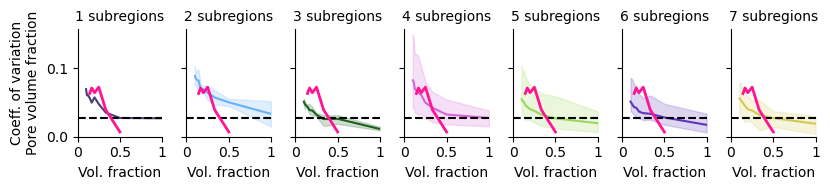

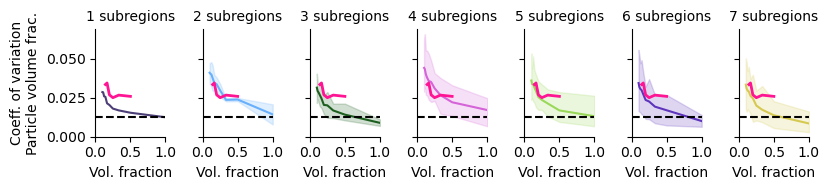

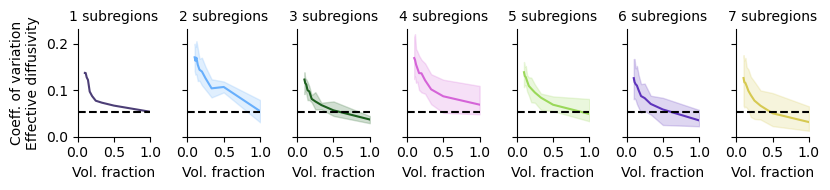

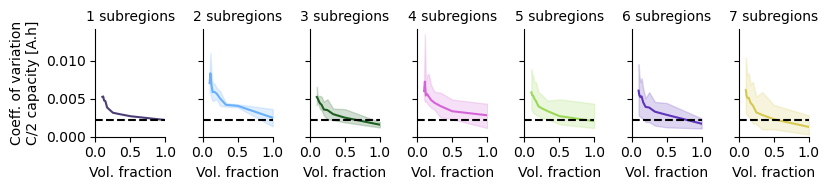

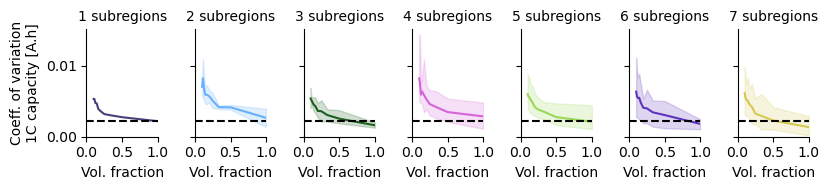

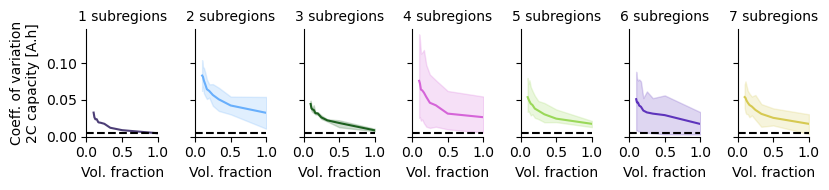

In [144]:
d = coefvar_0p2

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=colors, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "vf_pore", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nPore volume fraction")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0,None))
go.set_xticklabels(["0","0.5","1"])
go.refline(y=horzline_values.loc[0, 'vf_pore'], color='k', linestyle='--')
axes = go.fig.axes
for i, ax in enumerate(axes):
    x = coefvar_2D['fraction_vol']
    y = coefvar_2D['vf_pore']
    ax.plot(x, y, '-', color='deeppink', linewidth=2)

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=colors, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "vf_particle", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nParticle volume frac.")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0,None))
go.refline(y=horzline_values.loc[0, 'vf_particle'], color='k', linestyle='--')
axes = go.fig.axes
for i, ax in enumerate(axes):
    x = coefvar_2D['fraction_vol']
    y = coefvar_2D['vf_particle']
    ax.plot(x, y, '-', color='deeppink', linewidth=2)

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=colors, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "D_eff", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nEffective diffusivity")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0,None))
go.refline(y=horzline_values.loc[0, 'D_eff'], color='k', linestyle='--')

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=colors, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_Cb2", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nC/2 capacity [A.h]")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0,None))
go.refline(y=horzline_values.loc[0, 'qdis_Cb2'], color='k', linestyle='--')

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=colors, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_1C", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\n1C capacity [A.h]")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0,None))
go.refline(y=horzline_values.loc[0, 'qdis_1C'], color='k', linestyle='--')

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=colors, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_2C", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\n2C capacity [A.h]")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0,None))
go.refline(y=horzline_values.loc[0, 'qdis_2C'], color='k', linestyle='--')

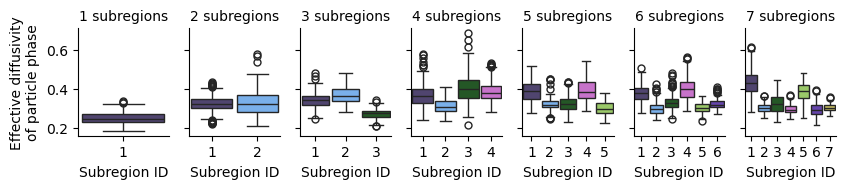

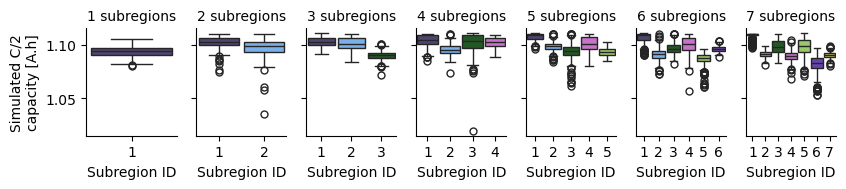

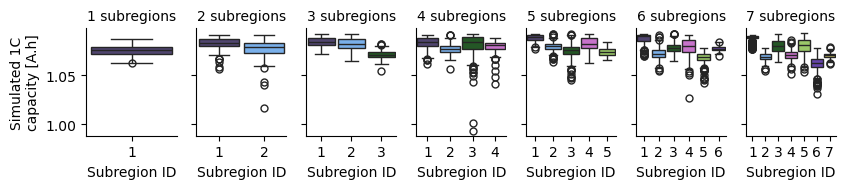

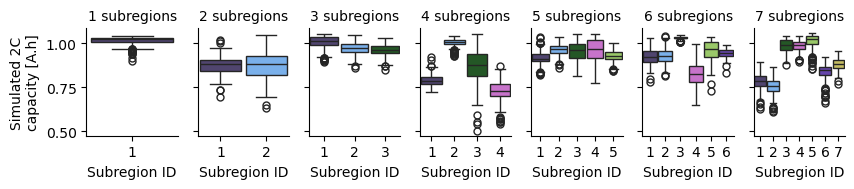

In [136]:
go = sns.catplot(data=volume_properties_0p2, y="vf_pore", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.6, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Volume fraction\nof pores")
go.set_titles("{col_name} subregions")
axes = go.fig.axes
for i, ax in enumerate(axes):
    mask = (volume_properties_2D['n_part'] - 1) == i
    x = volume_properties_2D.loc[mask, 'idx_part']
    y = volume_properties_2D.loc[mask, 'vf_pore']
    line = ax.plot(x, y, 'o', color='deeppink', markersize=8, markerfacecolor='none')

go = sns.catplot(data=volume_properties_0p2, y="vf_particle", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.6, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Volume fraction\nof particles")
go.set_titles("{col_name} subregions")
axes = go.fig.axes
for i, ax in enumerate(axes):
    mask = (volume_properties_2D['n_part'] - 1) == i
    x = volume_properties_2D.loc[mask, 'idx_part']
    y = volume_properties_2D.loc[mask, 'vf_particle']
    line = ax.plot(x, y, 'o', color='deeppink', markersize=8, markerfacecolor='none')

go = sns.catplot(data=volume_properties_0p2, y="D_eff", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.6, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Effective diffusivity\nof particle phase")
go.set_titles("{col_name} subregions")

go = sns.catplot(data=volume_properties_0p2, y="qdis_Cb2", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.6, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Simulated C/2\ncapacity [A.h]")
go.set_titles("{col_name} subregions")

go = sns.catplot(data=volume_properties_0p2, y="qdis_1C", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.6, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Simulated 1C\ncapacity [A.h]")
go.set_titles("{col_name} subregions")

go = sns.catplot(data=volume_properties_0p2, y="qdis_2C", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.6, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Simulated 2C\ncapacity [A.h]")
go.set_titles("{col_name} subregions")

(0.4, 1.15)

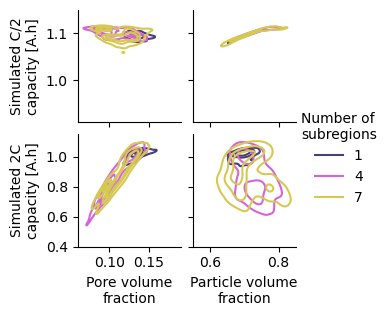

In [149]:
mask_subregions = np.logical_or(volume_properties_0p2['subregion'] == 1, volume_properties_0p2['subregion'] == 4)
mask_subregions = np.logical_or(mask_subregions, volume_properties_0p2['subregion'] == 7)
go = sns.pairplot(volume_properties_0p2.loc[mask_subregions], 
    hue='subregion', palette=[colors[0],colors[3],colors[6]], kind='kde',
    y_vars=['qdis_Cb2', 'qdis_2C'],
    x_vars=['vf_pore', 'vf_particle'],
    height=1.5, plot_kws={'levels':4})
go.y_vars = ['Simulated C/2\ncapacity [A.h]', 'Simulated 2C\ncapacity [A.h]']
go.x_vars = ['Pore volume\nfraction', 'Particle volume\nfraction']
go._add_axis_labels()
go._legend.set_title('Number of\nsubregions')
go.axes[0,0].set_xlim((0.06, 0.19))
go.axes[0,1].set_xlim((0.55, 0.85))
go.axes[0,0].set_ylim((0.91, 1.15))
go.axes[1,0].set_ylim((0.4, 1.15))

## Reduction study

In [26]:
coefvar_reduction = volume_properties_reduction.groupby(['reduction','n_part']).std() / volume_properties_reduction.groupby(['reduction','n_part']).mean()
coefvar_reduction = coefvar_reduction.drop(columns=['index', 'Unnamed: 0','fraction_vol','subregion','subregion_id','idx_part','idx_replicate']).reset_index()
coefvar_reduction['fraction_vol'] = 1 / coefvar_reduction['n_part']
coefvar_reduction

reduction  n_part  vf_particle   vf_pore     D_eff  qdis_Cb2   qdis_1C  \
0         0.2       1     0.012454  0.026988  0.053675  0.002187  0.002188   
1         0.2       2     0.015339  0.027433  0.066937  0.002692  0.002758   
2         0.2       3     0.016836  0.035235  0.073262  0.002987  0.003036   
3         0.2       4     0.017990  0.047814  0.077439  0.003150  0.003200   
4         0.2       5     0.020303  0.057574  0.087376  0.003560  0.003592   
5         0.2       6     0.021373  0.049800  0.097084  0.003854  0.003908   
6         0.2       7     0.025508  0.056626  0.122132  0.004675  0.004715   
7         0.2       8     0.025823  0.060476  0.127752  0.004755  0.004763   
8         0.2       9     0.028417  0.060563  0.137065  0.005287  0.005319   
9         0.2      10     0.028556  0.069559  0.137315  0.005225  0.005352   
10        0.4       1     0.010517  0.023372  0.077964  0.002613  0.002496   
11        0.4       2     0.015159  0.026816  0.099391  0.003846  0.003741   
12        0.4       3     0.015719  0.039178  0.119883  0.003706  0.003615   
13        0.4       4     0.018972  0.042058  0.115612  0.004638  0.004540   
14        0.4       5     0.020851  0.045579  0.140941  0.005557  0.005519   
15        0.4       6     0.022154  0.052323  0.148456  0.005982  0.005987   
16        0.4       7     0.028592  0.057149  0.155082  0.008695  0.009151   
17        0.4       8     0.024838  0.056724  0.162361  0.007315  0.007640   
18        0.4       9     0.029387  0.071882  0.173291  0.010245  0.010908   
19        0.4      10     0.031517  0.070210  0.193251  0.011649  0.012692   
20        0.6       1     0.008789  0.016068  0.030252  0.001458  0.001492   
21        0.6       2     0.009621  0.028242  0.033305  0.001537  0.001569   
22        0.6       3     0.009968  0.030275  0.033169  0.001603  0.001634   
23        0.6       4     0.012000  0.035765  0.039041  0.001782  0.001817   
24        0.6       5     0.012463  0.034438  0.042594  0.001847  0.001891   
25        0.6       6     0.013120  0.042675  0.043791  0.001833  0.001859   
26        0.6       7     0.015382  0.047765  0.051613  0.002258  0.002297   
27        0.6       8     0.014459  0.049314  0.046236  0.002041  0.002069   
28        0.6       9     0.015737  0.048592  0.052199  0.002239  0.002275   
29        0.6      10     0.016184  0.046115  0.056321  0.002364  0.002418   
30        0.8       1     0.008085  0.010796  0.030013  0.007886  0.008198   
31        0.8       2     0.009119  0.017191  0.048001  0.008988  0.009439   
32        0.8       3     0.014901  0.021994  0.056608  0.014425  0.014934   
33        0.8       4     0.020307  0.023149  0.081415  0.019477  0.020090   
34        0.8       5     0.019802  0.025942  0.073779  0.019037  0.019656   
35        0.8       6     0.024093  0.028919  0.091265  0.023158  0.023915   
36        0.8       7     0.022934  0.029598  0.080657  0.022092  0.022856   
37        0.8       8     0.028195  0.031114  0.111097  0.027162  0.028166   
38        0.8       9     0.029089  0.032789  0.107206  0.027783  0.028756   
39        0.8      10     0.029300  0.033980  0.106841  0.028141  0.029133   
40        1.0       1     0.005868  0.009933  0.017118  0.005617  0.005748   
41        1.0       2     0.008480  0.010538  0.026621  0.008113  0.008312   
42        1.0       3     0.007604  0.013234  0.029962  0.007295  0.007499   
43        1.0       4     0.012521  0.013132  0.040173  0.012048  0.012410   
44        1.0       5     0.011125  0.015855  0.045495  0.010796  0.011193   
45        1.0       6     0.013206  0.015854  0.045629  0.012678  0.013043   
46        1.0       7     0.016502  0.018544  0.052831  0.015781  0.016215   
47        1.0       8     0.017013  0.019231  0.053436  0.016312  0.016769   
48        1.0       9     0.018001  0.019386  0.058050  0.017240  0.017712   
49        1.0      10     0.017329  0.021314  0.060185  0.016558  0.017015   

     qdis_2C  output_sz  

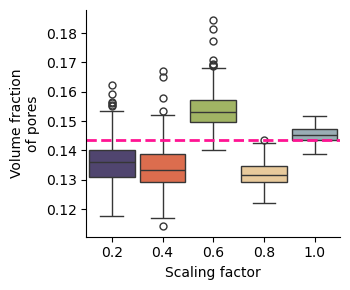

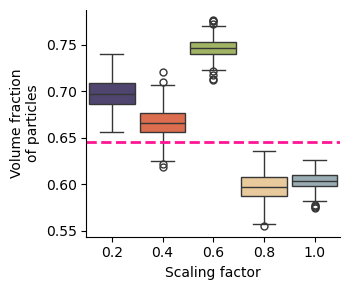

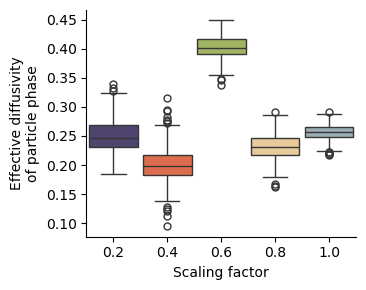

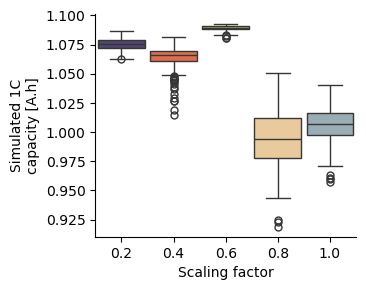

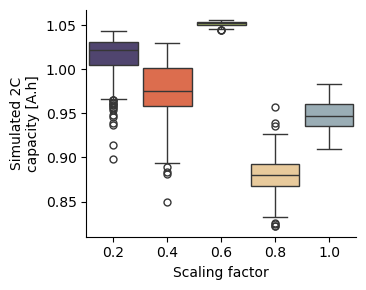

In [138]:
go = sns.catplot(data=volume_properties_reduction, y="vf_pore", x="reduction", palette=colors_reduction, hue='reduction',
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=3, legend=False)
go.set_axis_labels("Scaling factor", "Volume fraction\nof pores")
go.refline(y=volume_properties_2D.loc[0, 'vf_pore'], color='deeppink', linestyle='--', linewidth=2)

go = sns.catplot(data=volume_properties_reduction, y="vf_particle", x="reduction", palette=colors_reduction, hue='reduction',
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=3, legend=False)
go.set_axis_labels("Scaling factor", "Volume fraction\nof particles")
go.refline(y=volume_properties_2D.loc[0, 'vf_particle'], color='deeppink', linestyle='--', linewidth=2)

go = sns.catplot(data=volume_properties_reduction, y="D_eff", x="reduction", palette=colors_reduction, hue='reduction',
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=3, legend=False)
go.set_axis_labels("Scaling factor", "Effective diffusivity\nof particle phase")

go = sns.catplot(data=volume_properties_reduction, y="qdis_Cb2", x="reduction", palette=colors_reduction, hue='reduction',
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=3, legend=False)
go.set_axis_labels("Scaling factor", "Simulated C/2\ncapacity [A.h]")

go = sns.catplot(data=volume_properties_reduction, y="qdis_1C", x="reduction", palette=colors_reduction, hue='reduction',
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=3, legend=False)
go.set_axis_labels("Scaling factor", "Simulated 1C\ncapacity [A.h]")

go = sns.catplot(data=volume_properties_reduction, y="qdis_2C", x="reduction", palette=colors_reduction, hue='reduction',
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=3, legend=False)
go.set_axis_labels("Scaling factor", "Simulated 2C\ncapacity [A.h]")


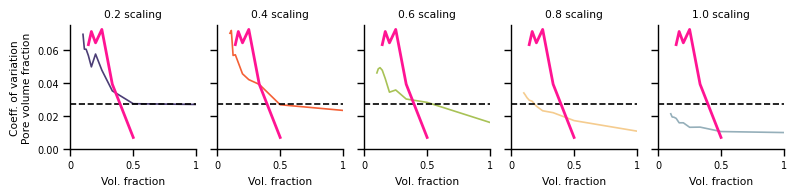

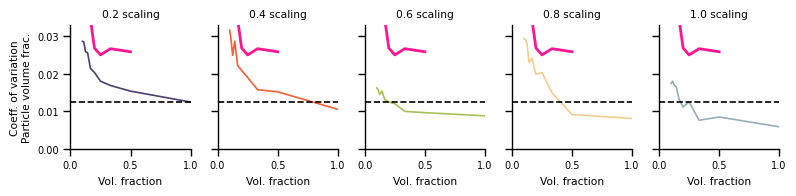

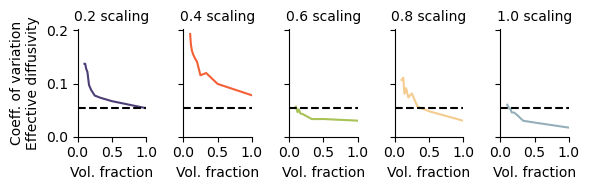

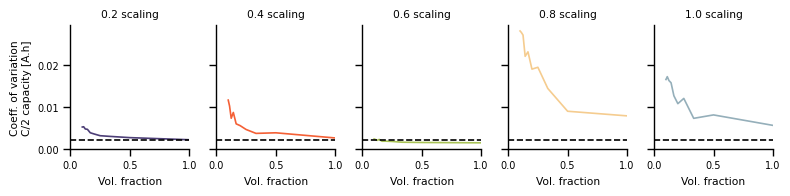

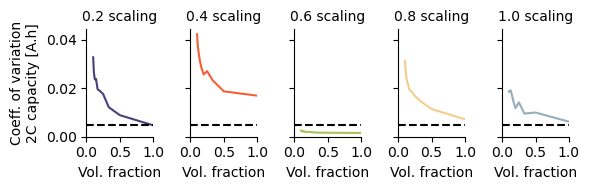

In [160]:
d = coefvar_reduction

with sns.plotting_context("paper", font_scale=0.8):
    go = sns.FacetGrid(d, col='reduction', hue='reduction',
                    palette=colors_reduction, aspect=0.8, height=2) #width=0.9, 
    go.map(sns.lineplot, "fraction_vol", "vf_pore", errorbar=('pi', 100))
    go.set_axis_labels("Vol. fraction", "Coeff. of variation\nPore volume fraction")
    go.set_titles("{col_name} scaling")
    go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0,None))
    go.set_xticklabels(["0","0.5","1"])
    go.refline(y=horzline_values.loc[0, 'vf_pore'], color='k', linestyle='--')
    axes = go.fig.axes
    for i, ax in enumerate(axes):
        x = coefvar_2D['fraction_vol']
        y = coefvar_2D['vf_pore']
        ax.plot(x, y, '-', color='deeppink', linewidth=2)

with sns.plotting_context("paper", font_scale=0.8):
    go = sns.FacetGrid(d, col='reduction', hue='reduction',
                    palette=colors_reduction, aspect=0.8, height=2) #width=0.9, 
    go.map(sns.lineplot, "fraction_vol", "vf_particle", errorbar=('pi', 100))
    go.set_axis_labels("Vol. fraction", "Coeff. of variation\nParticle volume frac.")
    go.set_titles("{col_name} scaling")
    go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0,None))
    go.refline(y=horzline_values.loc[0, 'vf_particle'], color='k', linestyle='--')
    axes = go.fig.axes
    for i, ax in enumerate(axes):
        x = coefvar_2D['fraction_vol']
        y = coefvar_2D['vf_particle']
        ax.plot(x, y, '-', color='deeppink', linewidth=2)

go = sns.FacetGrid(d, col='reduction', hue='reduction',
                   palette=colors_reduction, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "D_eff", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nEffective diffusivity")
go.set_titles("{col_name} scaling")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0,None))
go.refline(y=horzline_values.loc[0, 'D_eff'], color='k', linestyle='--')

with sns.plotting_context("paper", font_scale=0.8):
    go = sns.FacetGrid(d, col='reduction', hue='reduction',
                    palette=colors_reduction, aspect=0.8, height=2) #width=0.9, 
    go.map(sns.lineplot, "fraction_vol", "qdis_Cb2", errorbar=('pi', 100))
    go.set_axis_labels("Vol. fraction", "Coeff. of variation\nC/2 capacity [A.h]")
    go.set_titles("{col_name} scaling")
    go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0,None))
    go.refline(y=horzline_values.loc[0, 'qdis_Cb2'], color='k', linestyle='--')

go = sns.FacetGrid(d, col='reduction', hue='reduction',
                   palette=colors_reduction, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_1C", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\n1C capacity [A.h]")
go.set_titles("{col_name} scaling")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0,None))
go.refline(y=horzline_values.loc[0, 'qdis_1C'], color='k', linestyle='--')

go = sns.FacetGrid(d, col='reduction', hue='reduction',
                   palette=colors_reduction, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_2C", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\n2C capacity [A.h]")
go.set_titles("{col_name} scaling")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0,None))
go.refline(y=horzline_values.loc[0, 'qdis_2C'], color='k', linestyle='--')

(0.4, 1.15)

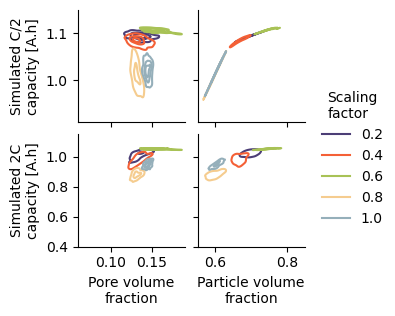

In [146]:
go = sns.pairplot(volume_properties_reduction, 
    hue='reduction', palette=colors_reduction, markers='o', kind='kde',
    y_vars=['qdis_Cb2', 'qdis_2C'],
    x_vars=['vf_pore', 'vf_particle'],
    height=1.5, plot_kws={'levels':5})
go.y_vars = ['Simulated C/2\ncapacity [A.h]', 'Simulated 2C\ncapacity [A.h]']
go.x_vars = ['Pore volume\nfraction', 'Particle volume\nfraction']
go._add_axis_labels()
go._legend.set_title('Scaling\nfactor')
go.axes[0,0].set_xlim((0.06, 0.19))
go.axes[0,1].set_xlim((0.55, 0.85))
go.axes[0,0].set_ylim((0.91, 1.15))
go.axes[1,0].set_ylim((0.4, 1.15))